In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from collections import deque
from keras.models import Sequential, Input, Model
from keras.layers import LSTM, Bidirectional, Dense, Dropout, RepeatVector, TimeDistributed, Lambda, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import initializers
#from tcn import TCN
from nbeats_keras.model import NBeatsNet
#from attention_decoder import AttentionDecoder

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/EURGBP.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,0.6547,0.6547,0.6497,0.6504,0.6504,0.0
1,2003-01-02,0.6503,0.6627,0.6475,0.6494,0.6494,0.0
2,2003-01-03,0.6496,0.6516,0.6466,0.6472,0.6472,0.0
3,2003-01-06,0.6471,0.6523,0.6467,0.6502,0.6502,0.0
4,2003-01-07,0.6498,0.6510,0.6477,0.6490,0.6490,0.0


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4430,2019-12-25,0.85700,0.86070,0.84913,0.85700,0.85700,0.0
4431,2019-12-26,0.85520,0.85550,0.85290,0.85530,0.85530,0.0
4432,2019-12-27,0.85370,0.85632,0.85095,0.85380,0.85380,0.0
4433,2019-12-30,0.85406,0.85558,0.85128,0.85406,0.85406,0.0
4434,2019-12-31,0.85419,0.85480,0.84544,0.85426,0.85426,0.0


In [5]:
len(data)

4435

In [6]:
data = data.dropna()
data.isnull().values.any()

False

In [7]:
test_frac = 0.1
valid_frac = test_frac
split = len(data) - round((test_frac+valid_frac)*len(data))
#print(split)
val = round(valid_frac*len(data))
#print(val)
df_train = data[:split]
df_valid = data[split:split+val]
df_test = data[split+val:]

In [8]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))

3525
441
440


In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = MinMaxScaler()
sc = StandardScaler()
df_train_scale = sc.fit_transform(df_train['Close'].values.reshape(-1,1))
df_valid_scale = sc.transform(df_valid['Close'].values.reshape(-1,1))
df_test_scale = sc.transform(df_test['Close'].values.reshape(-1,1))

In [10]:
df_train_scale

array([[-1.51852694],
       [-1.53103984],
       [-1.55856822],
       ...,
       [ 1.00107028],
       [ 0.76595292],
       [ 0.9256175 ]])

In [11]:
input_time_step = 16
seasonality = 30 #14
output_time_step = [2,3,5,7,10]
epoch = 1000
batch_size = 32
validation_split=0.1
optimizer = 'adam'
loss = 'mean_squared_error'
dropout = 0.1
units = 100
dilations=[1, 2, 4, 8]
callback = EarlyStopping(monitor = 'val_loss',
                         min_delta = 1e-4, 
                         patience = 100, 
                         verbose=1, 
                         mode='auto', 
                         restore_best_weights=True)
RMSE = []
MAE = []

In [12]:
# Exponential Smoothing + Normalization
class ES(Layer):

    def __init__(self, horizon, m, batch_size, time_steps, **kwargs):
        self.horizon = horizon
        self.m = m
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        super(ES, self).__init__(**kwargs)

    # initialization of the learned parameters of exponential smoothing
    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(1,),
                                     initializer='uniform', trainable=True)
        self.init_seasonality = self.add_weight(name='init_seasonality', shape=(self.m,),
                                                initializer=initializers.Constant(value=0.8), trainable=True)
        self.init_seasonality_list = [K.slice(self.init_seasonality,(i,),(1,)) for i in range(self.m)]
        self.seasonality_queue = deque(self.init_seasonality_list, self.m)
        self.level = self.add_weight(name='init_level', shape=(1,),
                                     initializer=initializers.Constant(value=0.8), 
                                     trainable=True)
        super(ES, self).build(input_shape)  

    def call(self, x):

        # extract time-series from feature vector
        n_examples = K.int_shape(x)[0]
        if n_examples is None:
            n_examples = self.batch_size
        x1 = K.slice(x,(0,0,0),(1,self.time_steps,1))
        x1 = K.reshape(x1,(self.time_steps,))
        x2 = K.slice(x,(1,self.time_steps-1,0),(n_examples-1,1,1))
        x2 = K.reshape(x2,(n_examples-1,))
        ts = K.concatenate([x1,x2])
        
        x_norm = []  # normalized values of time-series
        ls = []      # coeffients for denormalization of forecasts
        
        l_t_minus_1 = self.level
        
        for i in range(n_examples+self.time_steps-1):
        
            # compute l_t
            y_t = ts[i]
            s_t = self.seasonality_queue.popleft()
            l_t = self.alpha * y_t / s_t + (1 - self.alpha) * l_t_minus_1
            
            # compute s_{t+m}
            s_t_plus_m = self.gamma * y_t / l_t + (1 - self.gamma) * s_t
            
            self.seasonality_queue.append(s_t_plus_m)
            
            # normalize y_t
            x_norm.append(y_t / (s_t * l_t))

            l_t_minus_1 = l_t

            if i >= self.time_steps-1:
                l = [l_t]*self.horizon
                l = K.concatenate(l)
                s = [self.seasonality_queue[i] for i in range(self.horizon)] # we assume here that horizon < m
                s = K.concatenate(s)
                ls_t = K.concatenate([K.expand_dims(l), K.expand_dims(s)])
                ls.append(K.expand_dims(ls_t,axis=0))  
       
        self.level = l_t
        x_norm = K.concatenate(x_norm)

        # create x_out
        x_out = []
        for i in range(n_examples):
            norm_features = K.slice(x_norm,(i,),(self.time_steps,))
            norm_features = K.expand_dims(norm_features,axis=0)
            x_out.append(norm_features)

        x_out = K.concatenate(x_out, axis=0)
        x_out = K.expand_dims(x_out)

        # create tensor of denormalization coefficients 
        denorm_coeff = K.concatenate(ls, axis=0)
        return [x_out, denorm_coeff]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2]), (input_shape[0], self.horizon, 2)]
    
class Denormalization(Layer):
    
    def __init__(self, **kwargs):
        super(Denormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Denormalization, self).build(input_shape)  

    def call(self, x):
        return x[0] * x[1][:,:,0] * x[1][:,:,1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [13]:
for step in output_time_step:
    
    # Creating supervised training dataset
    in_start = 0
    x_train = []
    y_train = []
    for i in range(len(df_train_scale)):
        in_end = in_start + input_time_step
        out_end = in_end + step
        if out_end < len(df_train_scale):
            x_train.append(df_train_scale[in_start:in_end, 0])
            y_train.append(df_train_scale[in_end:out_end, 0])
        in_start += 1
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    print(y_train.shape)
    
    # Creating supervised validation dataset
    in_start = 0
    x_train_valid = []
    y_train_valid = []
    for i in range(len(df_valid_scale)):
        in_end = in_start + input_time_step
        out_end = in_end + step
        if out_end < len(df_valid_scale):
            x_train_valid.append(df_valid_scale[in_start:in_end, 0])
            y_train_valid.append(df_valid_scale[in_end:out_end, 0])
        in_start += 1
    x_train_valid, y_train_valid = np.array(x_train_valid), np.array(y_train_valid)
    x_train_valid = np.reshape(x_train_valid, (x_train_valid.shape[0], x_train_valid.shape[1], 1))
    print(x_train_valid.shape)
    print(y_train_valid.shape)
    
    # Number of samples in training set is integer multiple of the batch size. It is a limitation of the ES-LSTM
    # implementation below
    if (x_train.shape[0] % batch_size) != 0:
        num = int(x_train.shape[0]/batch_size)
        #x_train = x_train[:num]
        #print(x_train.shape[0]-num)
        val = batch_size * num
        #print(val)
        x_train = x_train[:val]
        print(x_train.shape)
        y_train = y_train[:val]
        print(y_train.shape)
    
    
    # Number of samples in validation set is integer multiple of batch size
    if (x_train_valid.shape[0] % batch_size) != 0:
        num = int(x_train_valid.shape[0]/batch_size)
        #x_train = x_train[:num]
        #print(x_train.shape[0]-num)
        val = batch_size * num
        #print(val)
        x_train_valid = x_train_valid[:val]
        print(x_train_valid.shape)
        y_train_valid = y_train_valid[:val]
        print(y_train_valid.shape)
        
    
    # ES-LSTM Model
    model_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
    [normalized_input, denormalization_coeff] = ES(step, seasonality, batch_size, input_time_step)(model_input)
    lstm_out = LSTM(units)(normalized_input)
    model_output_normalized = Dense(step)(lstm_out)
    model_output = Denormalization()([model_output_normalized, denormalization_coeff])
    model = Model(inputs=model_input, outputs=model_output)
    model.compile(optimizer = optimizer, loss = loss)
    
    
    # Training Model
    history = model.fit(x_train, 
                        y_train,
                        validation_data = (x_train_valid, y_train_valid),
                        callbacks = [callback], 
                        epochs = epoch, 
                        batch_size = batch_size, 
                        shuffle = False)

    
    
    #Preparing test dataset
    in_start = 0
    x_test = []
    real = []
    for i in range(len(df_test_scale)):
        in_end = in_start + input_time_step
        out_end = in_end + step
        if out_end < len(df_test_scale):
            x_test.append(df_test_scale[in_start:in_end, 0])
            real.append(df_test_scale[in_end:out_end, 0])
        in_start += 1
    x_test, real = np.array(x_test), np.array(real)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    print(x_test.shape)
    print(real.shape)
    
    
    # Number of samples in test set is integer multiple of the batch size.
    if (x_test.shape[0] % batch_size) != 0:
        num = int(x_test.shape[0]/batch_size)
        val = batch_size * num
        x_test = x_test[:val]
        real = real[:val]
        print(x_test.shape)
        print(real.shape)
    
    # Prediction on Test Set
    predictions = model.predict(x_test, batch_size=batch_size)
    predictions = sc.inverse_transform(predictions)
    real = sc.inverse_transform(real)
    
    
    # Calculate Accuracy
    sum_mae = 0
    sum_rmse = 0
    for i in range(len(predictions)):#same as real_vector
        mae = metrics.mean_absolute_error(real[i], predictions[i])
        mse = metrics.mean_squared_error(real[i], predictions[i])
        rmse = np.sqrt(mse)
        sum_mae = sum_mae + mae
        sum_rmse = sum_rmse + rmse

    # Average MAE
    avg_mae = sum_mae / len(predictions)
    # Average RMSE
    avg_rmse = sum_rmse / len(predictions)
    
    RMSE.append(avg_rmse)
    MAE.append(avg_mae)

(3507, 16, 1)
(3507, 2)
(423, 16, 1)
(423, 2)
(3488, 16, 1)
(3488, 2)
(416, 16, 1)
(416, 2)
Train on 3488 samples, validate on 416 samples
Epoch 1/1000
3488/3488 [==============================] - 3s 948us/step - loss: 0.1051 - val_loss: 0.1021
Epoch 2/1000
3488/3488 [==============================] - 1s 306us/step - loss: 0.0386 - val_loss: 0.0535
Epoch 3/1000
3488/3488 [==============================] - 1s 319us/step - loss: 0.0243 - val_loss: 0.0362
Epoch 4/1000
3488/3488 [==============================] - 1s 323us/step - loss: 0.0187 - val_loss: 0.0244
Epoch 5/1000
3488/3488 [==============================] - 1s 323us/step - loss: 0.0152 - val_loss: 0.0163
Epoch 6/1000
3488/3488 [==============================] - 1s 407us/step - loss: 0.0127 - val_loss: 0.0116
Epoch 7/1000
3488/3488 [==============================] - 2s 520us/step - loss: 0.0110 - val_loss: 0.0102
Epoch 8/1000
3488/3488 [==============================] - 2s 551us/step - loss: 0.0098 - val_loss: 0.0100
Epoch 9/1000


3488/3488 [==============================] - 1s 412us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 77/1000
3488/3488 [==============================] - 1s 296us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 78/1000
3488/3488 [==============================] - 2s 437us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 79/1000
3488/3488 [==============================] - 2s 473us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 80/1000
3488/3488 [==============================] - 2s 500us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 81/1000
3488/3488 [==============================] - 2s 509us/step - loss: 0.0044 - val_loss: 0.0048
Epoch 82/1000
3488/3488 [==============================] - 2s 520us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 83/1000
3488/3488 [==============================] - 2s 505us/step - loss: 0.0045 - val_loss: 0.0055
Epoch 84/1000
3488/3488 [==============================] - 2s 509us/step - loss: 0.0046 - val_loss: 0.0053
Epoch 85/1000
3488/3488 [==========================

3488/3488 [==============================] - 2s 474us/step - loss: 0.0043 - val_loss: 0.0050
Epoch 153/1000
3488/3488 [==============================] - 2s 494us/step - loss: 0.0044 - val_loss: 0.0051
Epoch 154/1000
3488/3488 [==============================] - 2s 472us/step - loss: 0.0044 - val_loss: 0.0050
Epoch 155/1000
3488/3488 [==============================] - 2s 489us/step - loss: 0.0044 - val_loss: 0.0051
Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
(422, 16, 1)
(422, 2)
(416, 16, 1)
(416, 2)
(3506, 16, 1)
(3506, 3)
(422, 16, 1)
(422, 3)
(3488, 16, 1)
(3488, 3)
(416, 16, 1)
(416, 3)
Train on 3488 samples, validate on 416 samples
Epoch 1/1000
3488/3488 [==============================] - 4s 1ms/step - loss: 0.2857 - val_loss: 0.0329
Epoch 2/1000
3488/3488 [==============================] - 2s 440us/step - loss: 0.1539 - val_loss: 0.0159
Epoch 3/1000
3488/3488 [==============================] - 2s 470us/step - loss: 0.1287 - val_loss: 0.0457


3488/3488 [==============================] - 1s 348us/step - loss: 0.0738 - val_loss: 0.0535
Epoch 72/1000
3488/3488 [==============================] - 1s 345us/step - loss: 0.0720 - val_loss: 0.0538
Epoch 73/1000
3488/3488 [==============================] - 1s 345us/step - loss: 0.0704 - val_loss: 0.0539
Epoch 74/1000
3488/3488 [==============================] - 1s 375us/step - loss: 0.0789 - val_loss: 0.0546
Epoch 75/1000
3488/3488 [==============================] - 2s 497us/step - loss: 0.0746 - val_loss: 0.0542
Epoch 76/1000
3488/3488 [==============================] - 2s 500us/step - loss: 0.0685 - val_loss: 0.0535
Epoch 77/1000
3488/3488 [==============================] - 2s 499us/step - loss: 0.0716 - val_loss: 0.0541
Epoch 78/1000
3488/3488 [==============================] - 2s 502us/step - loss: 0.0708 - val_loss: 0.0532
Epoch 79/1000
3488/3488 [==============================] - 2s 501us/step - loss: 0.0654 - val_loss: 0.0527
Epoch 80/1000
3488/3488 [==========================

3488/3488 [==============================] - 2s 509us/step - loss: 0.1484 - val_loss: 0.0257
Epoch 38/1000
3488/3488 [==============================] - 2s 504us/step - loss: 0.1601 - val_loss: 0.0262
Epoch 39/1000
3488/3488 [==============================] - 2s 477us/step - loss: 0.1583 - val_loss: 0.0260
Epoch 40/1000
3488/3488 [==============================] - 2s 509us/step - loss: 0.1483 - val_loss: 0.0261
Epoch 41/1000
3488/3488 [==============================] - 2s 488us/step - loss: 0.1402 - val_loss: 0.0263
Epoch 42/1000
3488/3488 [==============================] - 2s 478us/step - loss: 17.8556 - val_loss: 0.6392
Epoch 43/1000
3488/3488 [==============================] - 2s 480us/step - loss: 0.5910 - val_loss: 0.4843
Epoch 44/1000
3488/3488 [==============================] - 2s 496us/step - loss: 0.5763 - val_loss: 0.4250
Epoch 45/1000
3488/3488 [==============================] - 2s 558us/step - loss: 0.5658 - val_loss: 0.3951
Epoch 46/1000
3488/3488 [=========================

3488/3488 [==============================] - 2s 482us/step - loss: 0.1648 - val_loss: 0.1486
Epoch 114/1000
3488/3488 [==============================] - 2s 497us/step - loss: 0.1624 - val_loss: 0.1451
Epoch 115/1000
3488/3488 [==============================] - 2s 542us/step - loss: 0.1570 - val_loss: 0.1389
Epoch 116/1000
3488/3488 [==============================] - 2s 555us/step - loss: 0.1592 - val_loss: 0.1395
Epoch 117/1000
3488/3488 [==============================] - 2s 433us/step - loss: 0.1478 - val_loss: 0.1247
Epoch 118/1000
3488/3488 [==============================] - 2s 484us/step - loss: 0.1592 - val_loss: 0.1349
Epoch 119/1000
3488/3488 [==============================] - 2s 508us/step - loss: 0.1575 - val_loss: 0.1189
Epoch 120/1000
3488/3488 [==============================] - 2s 491us/step - loss: 0.1434 - val_loss: 0.1160
Epoch 121/1000
3488/3488 [==============================] - 2s 458us/step - loss: 0.1379 - val_loss: 0.1118
Epoch 122/1000
3488/3488 [=================

3488/3488 [==============================] - 2s 507us/step - loss: 0.1063 - val_loss: 4.9872
Epoch 52/1000
3488/3488 [==============================] - 2s 495us/step - loss: 0.1042 - val_loss: 7.2691
Epoch 53/1000
3488/3488 [==============================] - 2s 486us/step - loss: 0.1022 - val_loss: 8.3326
Epoch 54/1000
3488/3488 [==============================] - 2s 486us/step - loss: 0.1004 - val_loss: 12.6213
Epoch 55/1000
3488/3488 [==============================] - 2s 485us/step - loss: 0.0987 - val_loss: 70.0993
Epoch 56/1000
3488/3488 [==============================] - 2s 485us/step - loss: 0.0971 - val_loss: 76.1900
Epoch 57/1000
3488/3488 [==============================] - 2s 486us/step - loss: 0.0957 - val_loss: 4.1867
Epoch 58/1000
3488/3488 [==============================] - 2s 482us/step - loss: 0.0945 - val_loss: 6.2981
Epoch 59/1000
3488/3488 [==============================] - 2s 487us/step - loss: 0.0935 - val_loss: 0.3270
Epoch 60/1000
3488/3488 [=======================

3488/3488 [==============================] - 2s 489us/step - loss: 0.0309 - val_loss: 0.0970
Epoch 128/1000
3488/3488 [==============================] - 2s 505us/step - loss: 0.0309 - val_loss: 0.0959
Epoch 129/1000
3488/3488 [==============================] - 2s 479us/step - loss: 0.0306 - val_loss: 0.1210
Epoch 130/1000
3488/3488 [==============================] - 1s 423us/step - loss: 0.0302 - val_loss: 0.1015
Epoch 131/1000
3488/3488 [==============================] - 2s 484us/step - loss: 0.0300 - val_loss: 0.1192
Epoch 132/1000
3488/3488 [==============================] - 2s 506us/step - loss: 0.0299 - val_loss: 0.1530
Epoch 133/1000
3488/3488 [==============================] - 2s 501us/step - loss: 0.0313 - val_loss: 0.2455
Epoch 134/1000
3488/3488 [==============================] - 2s 492us/step - loss: 0.0348 - val_loss: 1.7952
Epoch 135/1000
3488/3488 [==============================] - 2s 497us/step - loss: 5841.5401 - val_loss: 1.2403
Epoch 136/1000
3488/3488 [==============

Epoch 203/1000
3488/3488 [==============================] - 2s 473us/step - loss: 0.1268 - val_loss: 0.2872
Epoch 204/1000
3488/3488 [==============================] - 2s 469us/step - loss: 0.1264 - val_loss: 0.2859
Epoch 205/1000
3488/3488 [==============================] - 2s 499us/step - loss: 0.1259 - val_loss: 0.2846
Epoch 206/1000
3488/3488 [==============================] - 2s 524us/step - loss: 0.1254 - val_loss: 0.2834
Epoch 207/1000
3488/3488 [==============================] - 2s 507us/step - loss: 0.1249 - val_loss: 0.2822
Epoch 208/1000
3488/3488 [==============================] - 2s 537us/step - loss: 0.1244 - val_loss: 0.2810
Epoch 209/1000
3488/3488 [==============================] - 2s 490us/step - loss: 0.1238 - val_loss: 0.2799
Epoch 210/1000
3488/3488 [==============================] - 2s 501us/step - loss: 0.1233 - val_loss: 0.2788
Epoch 211/1000
3488/3488 [==============================] - 2s 500us/step - loss: 0.1227 - val_loss: 0.2778
Epoch 212/1000
3488/3488 [==

Epoch 51/1000
3488/3488 [==============================] - 2s 518us/step - loss: 0.0391 - val_loss: 0.0231
Epoch 52/1000
3488/3488 [==============================] - 2s 520us/step - loss: 0.0382 - val_loss: 0.0229
Epoch 53/1000
3488/3488 [==============================] - 2s 532us/step - loss: 0.0376 - val_loss: 0.0232
Epoch 54/1000
3488/3488 [==============================] - 2s 521us/step - loss: 0.0367 - val_loss: 0.0230
Epoch 55/1000
3488/3488 [==============================] - 2s 569us/step - loss: 0.0361 - val_loss: 0.0228
Epoch 56/1000
3488/3488 [==============================] - 2s 540us/step - loss: 0.0351 - val_loss: 0.0231
Epoch 57/1000
3488/3488 [==============================] - 2s 520us/step - loss: 0.0346 - val_loss: 0.0233
Epoch 58/1000
3488/3488 [==============================] - 2s 559us/step - loss: 0.0338 - val_loss: 0.0229
Epoch 59/1000
3488/3488 [==============================] - 2s 586us/step - loss: 0.0330 - val_loss: 0.0244
Epoch 60/1000
3488/3488 [============

3488/3488 [==============================] - 2s 478us/step - loss: 0.0139 - val_loss: 0.0231
Epoch 128/1000
3488/3488 [==============================] - 2s 537us/step - loss: 0.0139 - val_loss: 0.0233
Epoch 129/1000
3488/3488 [==============================] - 2s 536us/step - loss: 0.0139 - val_loss: 0.0230
Epoch 130/1000
3488/3488 [==============================] - 2s 533us/step - loss: 0.0139 - val_loss: 0.0231
Epoch 131/1000
3488/3488 [==============================] - 2s 516us/step - loss: 0.0139 - val_loss: 0.0229
Epoch 132/1000
3488/3488 [==============================] - 2s 516us/step - loss: 0.0138 - val_loss: 0.0231
Epoch 133/1000
3488/3488 [==============================] - 2s 518us/step - loss: 0.0138 - val_loss: 0.0228
Epoch 134/1000
3488/3488 [==============================] - 1s 303us/step - loss: 0.0138 - val_loss: 0.0233
Epoch 135/1000
3488/3488 [==============================] - 2s 476us/step - loss: 0.0138 - val_loss: 0.0227
Epoch 136/1000
3488/3488 [=================

Epoch 203/1000
3488/3488 [==============================] - 2s 485us/step - loss: 0.0134 - val_loss: 0.0219
Epoch 204/1000
3488/3488 [==============================] - 2s 486us/step - loss: 0.0133 - val_loss: 0.0213
Epoch 205/1000
3488/3488 [==============================] - 1s 421us/step - loss: 0.0134 - val_loss: 0.0212
Epoch 206/1000
3488/3488 [==============================] - 2s 465us/step - loss: 0.0134 - val_loss: 0.0209
Epoch 207/1000
3488/3488 [==============================] - 2s 486us/step - loss: 0.0135 - val_loss: 0.0216
Epoch 208/1000
3488/3488 [==============================] - 2s 497us/step - loss: 0.0135 - val_loss: 0.0208
Epoch 209/1000
3488/3488 [==============================] - 2s 531us/step - loss: 0.0134 - val_loss: 0.0220
Epoch 210/1000
3488/3488 [==============================] - 2s 488us/step - loss: 0.0133 - val_loss: 0.0210
Epoch 211/1000
3488/3488 [==============================] - 2s 488us/step - loss: 0.0134 - val_loss: 0.0219
Epoch 212/1000
3488/3488 [==

Epoch 279/1000
3488/3488 [==============================] - 2s 462us/step - loss: 0.0145 - val_loss: 0.0212
Epoch 280/1000
3488/3488 [==============================] - 2s 462us/step - loss: 0.0145 - val_loss: 0.0211
Epoch 281/1000
3488/3488 [==============================] - 2s 464us/step - loss: 0.0144 - val_loss: 0.0211
Epoch 282/1000
3488/3488 [==============================] - 2s 484us/step - loss: 0.0144 - val_loss: 0.0212
Epoch 283/1000
3488/3488 [==============================] - 2s 466us/step - loss: 0.0143 - val_loss: 0.0213
Epoch 284/1000
3488/3488 [==============================] - 2s 463us/step - loss: 0.0143 - val_loss: 0.0212
Epoch 285/1000
3488/3488 [==============================] - 2s 462us/step - loss: 0.0142 - val_loss: 0.0213
Epoch 286/1000
3488/3488 [==============================] - 1s 407us/step - loss: 0.0142 - val_loss: 0.0215
Epoch 287/1000
3488/3488 [==============================] - 2s 470us/step - loss: 0.0143 - val_loss: 0.0211
Epoch 288/1000
3488/3488 [==

Epoch 355/1000
3488/3488 [==============================] - 2s 501us/step - loss: 0.0130 - val_loss: 0.0202
Epoch 356/1000
3488/3488 [==============================] - 2s 507us/step - loss: 0.0130 - val_loss: 0.0195
Epoch 357/1000
3488/3488 [==============================] - 2s 506us/step - loss: 0.0128 - val_loss: 0.0206
Epoch 358/1000
3488/3488 [==============================] - 2s 507us/step - loss: 0.0130 - val_loss: 0.0206
Epoch 359/1000
3488/3488 [==============================] - 2s 543us/step - loss: 0.0124 - val_loss: 0.0197
Epoch 360/1000
3488/3488 [==============================] - 2s 516us/step - loss: 0.0124 - val_loss: 0.0222
Epoch 361/1000
3488/3488 [==============================] - 2s 495us/step - loss: 0.0126 - val_loss: 0.0199
Epoch 362/1000
3488/3488 [==============================] - 2s 489us/step - loss: 0.0129 - val_loss: 0.0209
Epoch 363/1000
3488/3488 [==============================] - 2s 525us/step - loss: 0.0131 - val_loss: 0.0211
Epoch 364/1000
3488/3488 [==

Epoch 431/1000
3488/3488 [==============================] - 1s 279us/step - loss: 0.0117 - val_loss: 0.0190
Epoch 432/1000
3488/3488 [==============================] - 2s 436us/step - loss: 0.0116 - val_loss: 0.0199
Epoch 433/1000
3488/3488 [==============================] - 2s 482us/step - loss: 0.0116 - val_loss: 0.0192
Epoch 434/1000
3488/3488 [==============================] - 2s 488us/step - loss: 0.0117 - val_loss: 0.0200
Epoch 435/1000
3488/3488 [==============================] - 2s 492us/step - loss: 0.0115 - val_loss: 0.0192
Epoch 436/1000
3488/3488 [==============================] - 2s 526us/step - loss: 0.0114 - val_loss: 0.0192
Epoch 437/1000
3488/3488 [==============================] - 2s 487us/step - loss: 0.0116 - val_loss: 0.0193
Epoch 438/1000
3488/3488 [==============================] - 2s 495us/step - loss: 0.0117 - val_loss: 0.0200
Epoch 439/1000
3488/3488 [==============================] - 1s 408us/step - loss: 0.0115 - val_loss: 0.0191
Epoch 440/1000
3488/3488 [==

Epoch 507/1000
3488/3488 [==============================] - 2s 560us/step - loss: 0.0109 - val_loss: 0.0198
Epoch 508/1000
3488/3488 [==============================] - 2s 513us/step - loss: 0.0110 - val_loss: 0.0197
Epoch 509/1000
3488/3488 [==============================] - 1s 425us/step - loss: 0.0109 - val_loss: 0.0199
Epoch 510/1000
3488/3488 [==============================] - 1s 421us/step - loss: 0.0109 - val_loss: 0.0204
Epoch 511/1000
3488/3488 [==============================] - 2s 443us/step - loss: 0.0109 - val_loss: 0.0186
Epoch 512/1000
3488/3488 [==============================] - 2s 462us/step - loss: 0.0109 - val_loss: 0.0198
Epoch 513/1000
3488/3488 [==============================] - 2s 462us/step - loss: 0.0108 - val_loss: 0.0198
Epoch 514/1000
3488/3488 [==============================] - 2s 464us/step - loss: 0.0124 - val_loss: 0.0187
Epoch 515/1000
3488/3488 [==============================] - 2s 463us/step - loss: 0.0129 - val_loss: 0.0182
Epoch 516/1000
3488/3488 [==

In [14]:
RMSE

[0.0038677266045575075,
 0.007339803385888919,
 0.009700979222707741,
 0.014525661550505152,
 0.008495873621776185]

In [15]:
MAE

[0.00355823157388431,
 0.006949574571450555,
 0.008936729227295288,
 0.013633335905461511,
 0.007563901959498724]

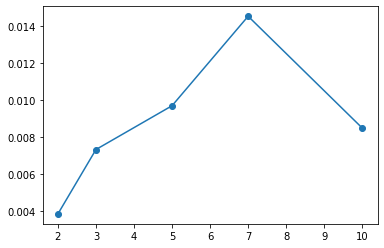

In [16]:
plt.plot(output_time_step,RMSE, marker='o')

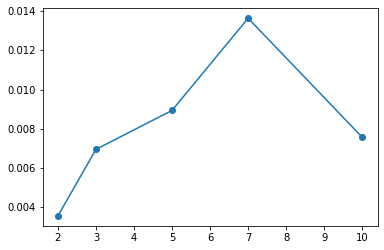

In [17]:
plt.plot(output_time_step,MAE, marker='o')